## **Weather Forecasting Module**

Fetch daily weather history via the free Open-Meteo API, turn it into a pandas DataFrame, and leave a clean hook for later modeling (AR/MA).

In [10]:
import requests
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
import numpy as np

DEFAULT_END = date.today()
DEFAULT_START = DEFAULT_END - timedelta(days=365)

## **Data Collection**

In [4]:
def geocode_city(city: str) -> tuple[float, float]:
    """Return (lat, lon) for a city name using Open-Meteo's free geocoding API."""
    url = "https://geocoding-api.open-meteo.com/v1/search"
    resp = requests.get(url, params={"name": city, "count": 1, "language": "en"}, timeout=10)
    resp.raise_for_status()
    data = resp.json()
    results = data.get("results") or []
    if not results:
        raise ValueError(f"No geocoding results for '{city}'")
    lat = results[0]["latitude"]
    lon = results[0]["longitude"]
    return lat, lon


In [5]:
def fetch_weather_timeseries(city: str, start: date | None = None, end: date | None = None) -> pd.DataFrame:
    """
    Fetch daily weather history (avg/min/max temp, precip) for a city into a DataFrame.

    Uses Open-Meteo's archive API. Dates are inclusive and must be in YYYY-MM-DD.
    """
    start = start or DEFAULT_START
    end = end or DEFAULT_END
    if start > end:
        raise ValueError("start date must be <= end date")

    lat, lon = geocode_city(city)

    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start.isoformat(),
        "end_date": end.isoformat(),
        "daily": [
            "temperature_2m_max",
            "temperature_2m_min",
            "temperature_2m_mean",
            "precipitation_sum",
        ],
        "timezone": "auto",
    }

    resp = requests.get(url, params=params, timeout=20)
    resp.raise_for_status()
    data = resp.json()

    # Build DataFrame safely
    daily = data.get("daily", {})
    df = pd.DataFrame(daily)
    if df.empty:
        raise ValueError("No weather data returned; check dates or API availability")

    df["time"] = pd.to_datetime(df["time"])
    df.set_index("time", inplace=True)
    df.rename(
        columns={
            "temperature_2m_max": "temp_max_c",
            "temperature_2m_min": "temp_min_c",
            "temperature_2m_mean": "temp_mean_c",
            "precipitation_sum": "precip_mm",
        },
        inplace=True,
    )
    return df


In [6]:
try:
    weather_df = fetch_weather_timeseries("Dubai")
    display(weather_df.head())
    display(weather_df.tail(3))
    print(f"Fetched {len(weather_df)} days spanning {weather_df.index.min().date()} to {weather_df.index.max().date()}")
except Exception as exc:
    print(f"Fetch failed: {exc}")


,temp_max_c,temp_min_c,temp_mean_c,precip_mm
time,,,,
2024-12-17,24.3,14.2,19.5,0.0
2024-12-18,23.9,18.9,21.1,0.1
2024-12-19,24.3,14.6,20.1,0.0
2024-12-20,25.4,14.2,19.5,0.0
2024-12-21,24.9,12.7,18.8,0.0


,temp_max_c,temp_min_c,temp_mean_c,precip_mm
time,,,,
2025-12-15,30.6,16.6,22.7,0.0
2025-12-16,26.7,20.3,23.1,0.0
2025-12-17,28.6,20.0,23.6,0.2


Fetched 366 days spanning 2024-12-17 to 2025-12-17


## **Data Exploration and Cleaning**

In [7]:
# Basic structure
print(weather_df.info())
print(weather_df.describe())

# Missing values check
print("\nMissing values per column:")
print(weather_df.isna().sum())

# Quick correlation snapshot
corr = weather_df.corr()
print("\nCorrelation matrix:")
display(corr)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2024-12-17 to 2025-12-17
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temp_max_c   366 non-null    float64
 1   temp_min_c   366 non-null    float64
 2   temp_mean_c  366 non-null    float64
 3   precip_mm    366 non-null    float64
dtypes: float64(4)
memory usage: 14.3 KB
None
       temp_max_c  temp_min_c  temp_mean_c   precip_mm
count   366.00000  366.000000   366.000000  366.000000
mean     35.09153   22.745082    28.330874    0.025137
std       7.23623    5.945613     6.192174    0.226158
min      21.10000   10.200000    16.800000    0.000000
25%      28.90000   17.625000    22.825000    0.000000
50%      36.00000   23.550000    29.150000    0.000000
75%      41.07500   27.700000    33.600000    0.000000
max      47.90000   33.300000    39.100000    3.800000

Missing values per column:
temp_max_c     0
temp_min_c     0
temp_mean_c    0
preci

,temp_max_c,temp_min_c,temp_mean_c,precip_mm
temp_max_c,1.000000,0.901195,0.973163,-0.091025
temp_min_c,0.901195,1.000000,0.972257,-0.084872
temp_mean_c,0.973163,0.972257,1.000000,-0.092349
precip_mm,-0.091025,-0.084872,-0.092349,1.000000


<Figure size 640x480 with 0 Axes>

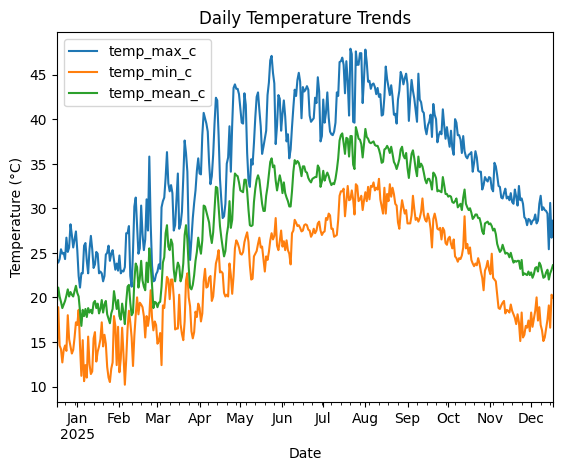

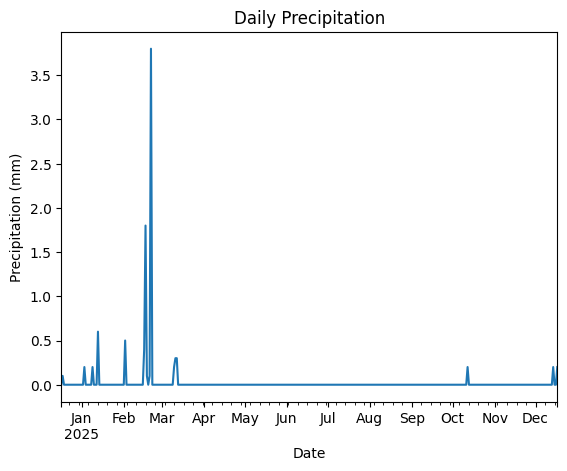

In [8]:
plt.figure()
weather_df[["temp_max_c", "temp_min_c", "temp_mean_c"]].plot()
plt.title("Daily Temperature Trends")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

plt.figure()
weather_df["precip_mm"].plot()
plt.title("Daily Precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.show()

In [11]:
df = weather_df.copy()

df["day_of_year"] = df.index.dayofyear

df["doy_sin"] = np.sin(2 * np.pi * df["day_of_year"] / 365.25)
df["doy_cos"] = np.cos(2 * np.pi * df["day_of_year"] / 365.25)

<Figure size 640x480 with 0 Axes>

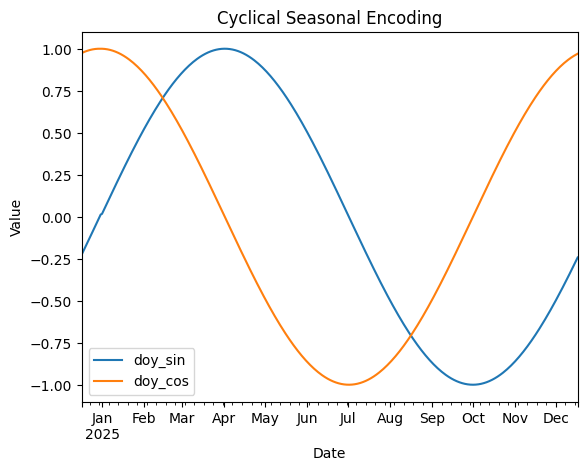

In [12]:
plt.figure()
df[["doy_sin", "doy_cos"]].plot()
plt.title("Cyclical Seasonal Encoding")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()